In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import model_selection
from sklearn import decomposition
from sklearn import linear_model
from sklearn import ensemble
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

from skimage.transform import rescale
from scipy import ndimage as ndi

matplotlib.style.use('fivethirtyeight')

C:\Users\lanwe\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


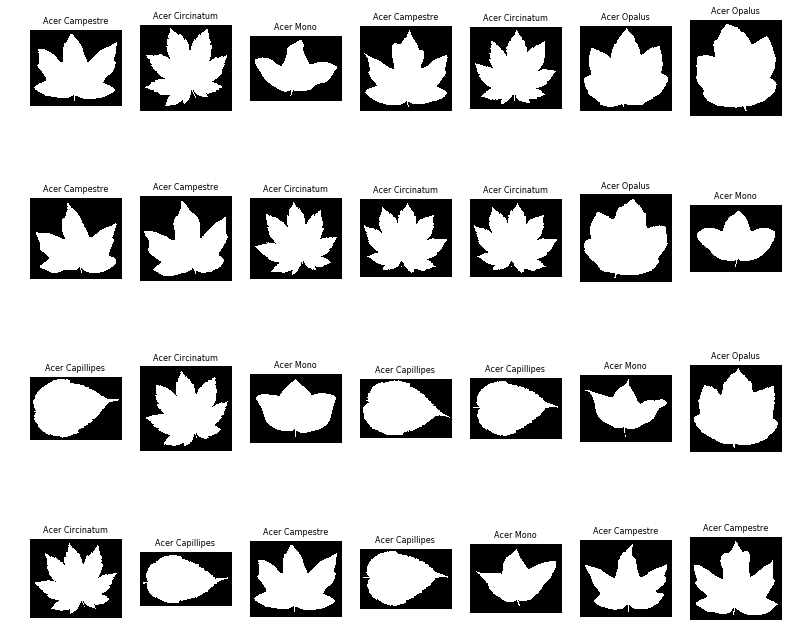

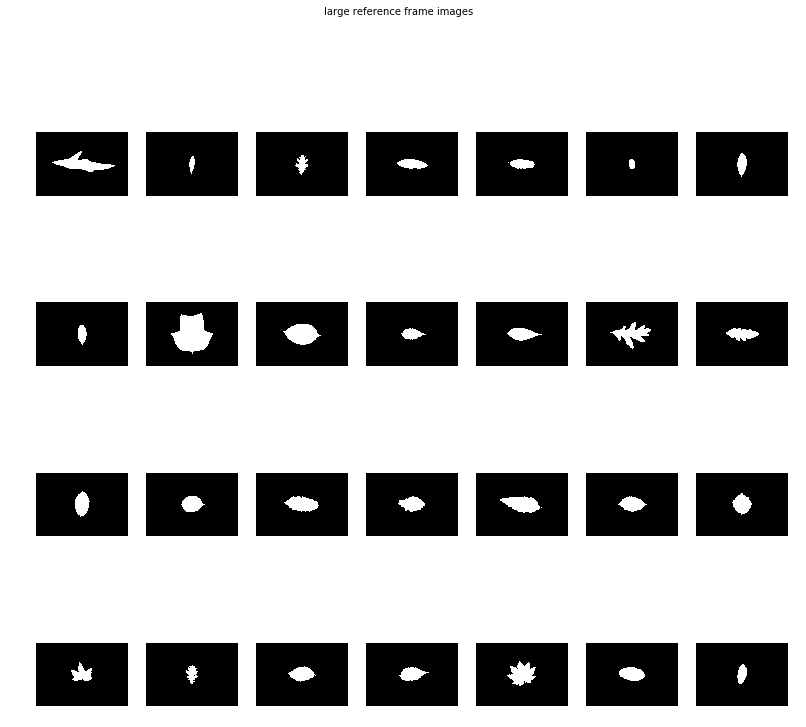

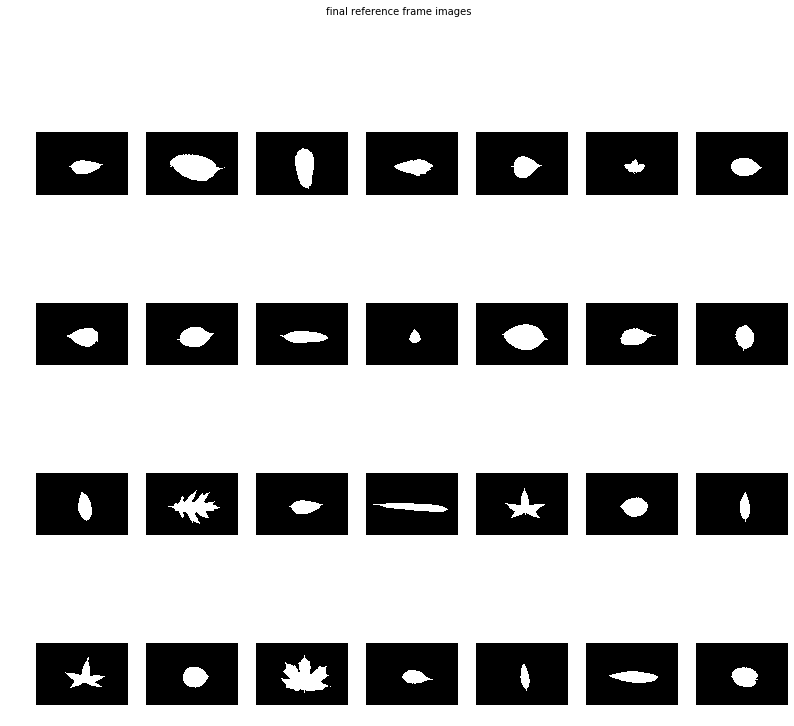

In [2]:
#%% load the data
dataDir = '../project/100 leaves plant species/'
trainData = pd.read_csv('../project/100 leaves plant species/train01.csv', error_bad_lines=False)
classEncoder = LabelEncoder()
trainLabels = classEncoder.fit_transform(trainData.loc[:,'species'])
trainIDs = np.array(trainData.loc[:,'id'])

# show some random images
plt.figure(figsize=(12,12))
for k in range(28):
    randTrainInd = np.random.randint(len(trainIDs))
    randomID = trainIDs[randTrainInd]
    imageFilename = '../project/100 leaves plant species/image/' + str(randomID) + '.jpg'
    plt.subplot(4,7,k+1); plt.imshow(mpimg.imread(imageFilename), cmap='gray')
    plt.title(classEncoder.classes_[trainLabels[randTrainInd]], fontsize=8); plt.axis('off')

#%% preprocess images

# go over training images and store them in a list
numImages = 1600

shapesMatrix = np.zeros((2,numImages))
listOfImages = []
for k in range(numImages):
    imageFilename = '../project/100 leaves plant species/image/' + str(k+1) + '.jpg'
    currImage = mpimg.imread(imageFilename)
    shapesMatrix[:,k] = np.shape(currImage)
    listOfImages.append(currImage)
    
# create a large 3d array with all images
maxShapeSize = shapesMatrix.max(axis=1)
for k in range(len(maxShapeSize)):
    if maxShapeSize[k] % 2 == 0:
        maxShapeSize[k] += 311
    else:
        maxShapeSize[k] += 310
    
fullImageMatrix3D = np.zeros(np.hstack((maxShapeSize,
                                        np.shape(shapesMatrix[1]))).astype(int),dtype=np.dtype('u1'))
destXc = (maxShapeSize[1]+1)/2; destYc = (maxShapeSize[0]+1)/2
for k, currImage in enumerate(listOfImages):
    Yc, Xc = ndi.center_of_mass(currImage)
    Xd = destXc - Xc; Yd = destYc - Yc
    rowIndLims = (int(round(Yd)),int(round(Yd)+np.shape(currImage)[0]))
    colIndLims = (int(round(Xd)),int(round(Xd)+np.shape(currImage)[1]))
    fullImageMatrix3D[rowIndLims[0]:rowIndLims[1],colIndLims[0]:colIndLims[1],k] = currImage

# make sure nothing was ruined in the process
plt.figure(figsize=(12,12))
plt.suptitle('large reference frame images', fontsize=10)
for k in range(28):
    randInd = np.random.randint(np.shape(fullImageMatrix3D)[2])
    plt.subplot(4,7,k+1); plt.imshow(fullImageMatrix3D[:,:,randInd], cmap='gray'); plt.axis('off')

# remove redundent rows and columns
xValid = fullImageMatrix3D.mean(axis=2).sum(axis=0) > 0
yValid = fullImageMatrix3D.mean(axis=2).sum(axis=1) > 0
xLims = (np.nonzero(xValid)[0][0],np.nonzero(xValid)[0][-1])
yLims = (np.nonzero(yValid)[0][0],np.nonzero(yValid)[0][-1])
fullImageMatrix3D = fullImageMatrix3D[yLims[0]:yLims[1],xLims[0]:xLims[1],:]

# make sure nothing was ruined in the process
plt.figure(figsize=(12,12))
plt.suptitle('final reference frame images', fontsize=10)
for k in range(28):
    randInd = np.random.randint(np.shape(fullImageMatrix3D)[2])
    plt.subplot(4,7,k+1); plt.imshow(fullImageMatrix3D[:,:,randInd], cmap='gray'); plt.axis('off')

# scale down all images
rescaleFactor = 0.15

scaledDownImage = rescale(fullImageMatrix3D[:,:,0],rescaleFactor)
scaledDownImages = np.zeros(np.hstack((np.shape(scaledDownImage),np.shape(fullImageMatrix3D)[2])),dtype=np.dtype('f4'))
for imInd in range(np.shape(fullImageMatrix3D)[2]):
    scaledDownImages[:,:,imInd] = rescale(fullImageMatrix3D[:,:,imInd],rescaleFactor)
    
del fullImageMatrix3D

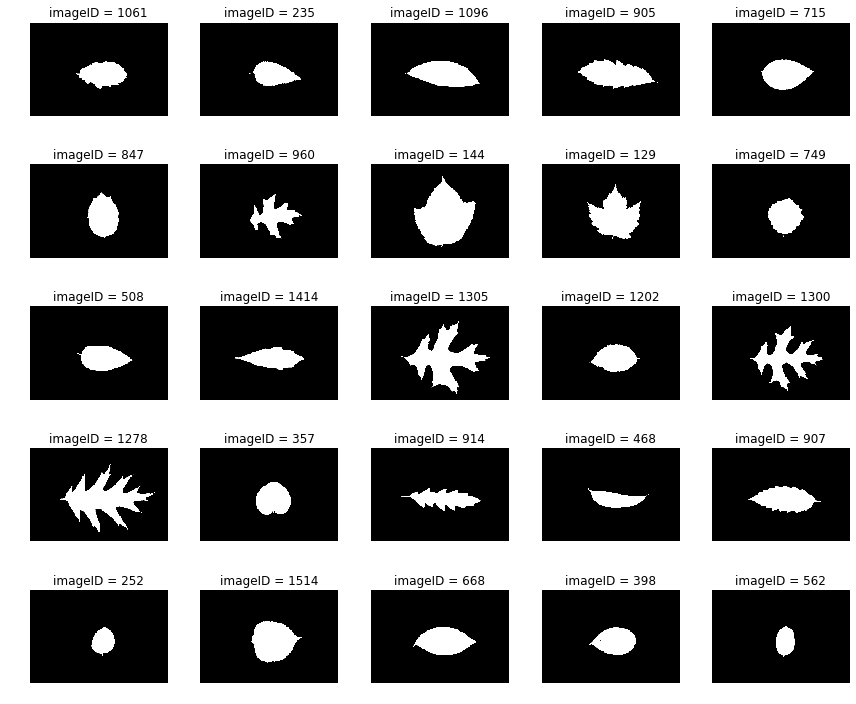

In [3]:
np.random.seed(1) # use a nice looking random seed

plt.figure(figsize=(12,10));
for k in range(25):
    randInd = np.random.randint(np.shape(scaledDownImages)[2])
    plt.subplot(5,5,k+1); 
    plt.imshow(scaledDownImages[:,:,randInd], cmap='gray'); 
    plt.axis('off'); plt.title('imageID = ' + str(randInd), fontsize=12)
plt.tight_layout()

In [4]:
class GaussianModel:
    def __init__(self, X, numBasisFunctions=10, objectPixels=None):
        '''
        inputs: 
            X                    - numSamples x numDimentions matrix
            numBasisFunctions       - number of basis function to use
            objectPixels (optional) - an binnary mask image used for presentation
                                      will be used as Im[objectPixels] = dataSample
                                      must satisfy objectPixels.ravel().sum() = X.shape[1]
        '''
        
        self.numBasisFunctions = numBasisFunctions        
        if objectPixels is None:
            self.objectPixels = np.ones((1,X.shape[1]),dtype=np.bool)
        else:
            self.objectPixels = objectPixels
        assert(self.objectPixels.ravel().sum() == X.shape[1])

        PCAModel = decomposition.PCA(n_components=numBasisFunctions, whiten=True)
        self.dataRepresentation = PCAModel.fit_transform(X)
        self.PCAModel = PCAModel

    def RepresentUsingModel(self, X):
        return self.PCAModel.transform(X)

    def ReconstructUsingModel(self, X_transformed):
        return self.PCAModel.inverse_transform(X_transformed)

    def InterpretUsingModel(self, X):
        return self.PCAModel.inverse_transform(self.PCAModel.transform(X))

    # shows the eigenvectors of the gaussian covariance matrix
    def ShowVarianceDirections(self, numDirectionsToShow=16):
        numDirectionsToShow = min(numDirectionsToShow, self.numBasisFunctions)
        
        numFigRows = 4; numFigCols = 4;
        numDirectionsPerFigure = numFigRows*numFigCols
        numFigures = int(np.ceil(float(numDirectionsToShow)/numDirectionsPerFigure))
        
        for figureInd in range(numFigures):
            plt.figure()
            for plotInd in range(numDirectionsPerFigure):
                eigVecInd = numDirectionsPerFigure*figureInd + plotInd
                if eigVecInd >= self.numBasisFunctions:
                    break
                deltaImage = np.zeros(np.shape(self.objectPixels))
                deltaImage[self.objectPixels] = self.PCAModel.components_[eigVecInd,:].ravel()

                plt.subplot(numFigRows,numFigCols,plotInd+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(deltaImage)
                else:
                    plt.imshow(deltaImage,cmap='jet'); plt.axis('off')
                titleStr = str(100*self.PCAModel.explained_variance_ratio_[eigVecInd])[0:5]
                plt.title(titleStr + '% explained');
            plt.tight_layout()
            
    # shows several random model reconstructions
    def ShowReconstructions(self, X, numReconstructions=5):
        assert(np.shape(X)[1] == self.objectPixels.ravel().sum())
        numSamples = np.shape(X)[0]
        numReconstructions = min(numReconstructions, numSamples)
        
        originalImage      = np.zeros(np.shape(self.objectPixels))
        reconstructedImage = np.zeros(np.shape(self.objectPixels))
        
        numReconstructionsPerFigure = min(5, numReconstructions)
        numFigures = int(np.ceil(float(numReconstructions)/numReconstructionsPerFigure))
        
        for figureInd in range(numFigures):
            plt.figure()
            for plotCol in range(numReconstructionsPerFigure):
                dataSampleInd = np.random.randint(numSamples)
                originalImage[self.objectPixels] = X[dataSampleInd,:].ravel()
                reconstructedImage[self.objectPixels] = \
                    self.InterpretUsingModel(np.reshape(X[dataSampleInd,:],[1,-1])).ravel()
                diffImage = abs(originalImage - reconstructedImage)
                
                # original image
                plt.subplot(3,numReconstructionsPerFigure,0*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(originalImage); plt.title('original signal')
                else:
                    plt.imshow(originalImage, cmap='gray'); 
                    plt.title('original image'); plt.axis('off')
                    
                # reconstred image
                plt.subplot(3,numReconstructionsPerFigure,1*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(reconstructedImage); plt.title('reconstructed signal')
                else:
                    plt.imshow(reconstructedImage, cmap='gray'); 
                    plt.title('reconstructed image'); plt.axis('off')

                # diff image
                plt.subplot(3,numReconstructionsPerFigure,2*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(diffImage); plt.title('abs difference signal')
                else:
                    plt.imshow(diffImage, cmap='gray'); 
                    plt.title('abs difference image'); plt.axis('off')
            plt.tight_layout()

    # shows distrbution along the variance directions and several images along that variance direction
    def ShowModelVariations(self, numVariations=5):

        showAsTraces = (np.shape(self.objectPixels)[0] == 1)
        numVariations = min(numVariations, self.numBasisFunctions)
                
        numVarsPerFigure = min(5,numVariations)
        numFigures = int(np.ceil(float(numVariations)/numVarsPerFigure))
        
        lowRepVec     = np.percentile(self.dataRepresentation, 2, axis=0)
        medianRepVec  = np.percentile(self.dataRepresentation, 50, axis=0)
        highRepVec    = np.percentile(self.dataRepresentation, 98, axis=0)

        for figureInd in range(numFigures):
            plt.figure()
            for plotCol in range(numVarsPerFigure):
                eigVecInd = numVarsPerFigure*figureInd+plotCol
                if eigVecInd >= self.numBasisFunctions:
                    break

                # create the low and high precentile representation activation vectors
                currLowPrecentileRepVec             = medianRepVec.copy()
                currLowPrecentileRepVec[eigVecInd]  = lowRepVec[eigVecInd]
                currHighPrecentileRepVec            = medianRepVec.copy()
                currHighPrecentileRepVec[eigVecInd] = highRepVec[eigVecInd]

                # create blank images
                deltaImage          = np.zeros(np.shape(self.objectPixels))
                medianImage         = np.zeros(np.shape(self.objectPixels))
                lowPrecentileImage  = np.zeros(np.shape(self.objectPixels))
                highPrecentileImage = np.zeros(np.shape(self.objectPixels))

                # fill the object pixels with the relevant data
                deltaImage[self.objectPixels]          = \
                        self.PCAModel.components_[eigVecInd,:].ravel()
                lowPrecentileImage[self.objectPixels]  = \
                        self.ReconstructUsingModel(currLowPrecentileRepVec).ravel()
                medianImage[self.objectPixels]         = \
                        self.ReconstructUsingModel(medianRepVec).ravel()
                highPrecentileImage[self.objectPixels] = \
                        self.ReconstructUsingModel(currHighPrecentileRepVec).ravel()

                # calculate the Gaussian smoothed distribution of values along the eignevector direction
                sigmaOfKDE = 0.12
                pdfStart   = min(self.dataRepresentation[:,eigVecInd]) - 3*sigmaOfKDE
                pdfStop    = max(self.dataRepresentation[:,eigVecInd]) + 3*sigmaOfKDE
                xAxis = np.linspace(pdfStart,pdfStop,200)
                PDF_Model = KernelDensity(kernel='gaussian', 
                                  bandwidth=sigmaOfKDE).fit(self.dataRepresentation[:,eigVecInd].reshape(-1,1))
                logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))

                # show distribution of current component 
                plt.subplot(5,numVarsPerFigure,0*numVarsPerFigure+plotCol+1)
                plt.fill(xAxis, np.exp(logPDF), fc='b');
                percentExplainedString = str(100*self.PCAModel.explained_variance_ratio_[eigVecInd])[0:5]
                plt.title(percentExplainedString + '% explained'); 
                
                # show variance direction (eigenvector)
                plt.subplot(5,numVarsPerFigure,1*numVarsPerFigure+plotCol+1);
                if showAsTraces:
                    plt.plot(deltaImage); plt.title('eigenvector ' + str(eigVecInd))
                else:
                    plt.imshow(deltaImage, cmap='jet'); 
                    plt.title('eigenvector ' + str(eigVecInd)); plt.axis('off')

                # show 2nd precentile image
                plt.subplot(5,numVarsPerFigure,2*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(lowPrecentileImage); plt.title('2nd precentile')
                else:
                    plt.imshow(lowPrecentileImage, cmap='gray'); 
                    plt.title('2nd precentile image'); plt.axis('off')

                # show median image
                plt.subplot(5,numVarsPerFigure,3*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(medianImage); plt.title('median signal')
                else:
                    plt.imshow(medianImage, cmap='gray'); 
                    plt.title('median Image'); plt.axis('off')

                # show 98th precentile image
                plt.subplot(5,numVarsPerFigure,4*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(highPrecentileImage); plt.title('98th precentile')
                else:
                    plt.imshow(highPrecentileImage, cmap='gray'); 
                    plt.title('98th precentile image'); plt.axis('off')
            plt.tight_layout()
        
    # shows distrbution along the variance directions and several images along that variance direction
    def ShowSingleComponentVariation(self, X, listOfComponents=[0,1]):

        showAsTraces = (np.shape(self.objectPixels)[0] == 1)
        assert(all([(x in range(self.numBasisFunctions)) for x in listOfComponents]))
                
        X_rep = self.RepresentUsingModel(X)
        
        percentilesToShow = [1,20,40,60,80,99]
        numReadDataSamplePerPercentile = 4
        representationPercentiles = []
        for percentile in percentilesToShow:
            representationPercentiles.append(np.percentile(self.dataRepresentation, percentile, axis=0))
        medianRepVec =  np.percentile(self.dataRepresentation, 50, axis=0)

        for eigVecInd in listOfComponents:
            plt.figure(); gs = gridspec.GridSpec(numReadDataSamplePerPercentile+2,
                                                 len(percentilesToShow))

            # calculate the Gaussian smoothed distribution of values along the eignevector direction
            sigmaOfKDE = 0.12
            pdfStart   = min(self.dataRepresentation[:,eigVecInd]) - 3*sigmaOfKDE
            pdfStop    = max(self.dataRepresentation[:,eigVecInd]) + 3*sigmaOfKDE
            xAxis = np.linspace(pdfStart,pdfStop,200)
            PDF_Model = KernelDensity(kernel='gaussian', 
                              bandwidth=sigmaOfKDE).fit(self.dataRepresentation[:,eigVecInd].reshape(-1,1))
            logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))
            percentileValuesToShow = \
                    [representationPercentiles[x][eigVecInd] for x in range(len(representationPercentiles))]
            percentilesToShowLogPDF = \
                    PDF_Model.score_samples(np.array(percentileValuesToShow).reshape(-1,1))

            # show distribution of current component and red dots at the list of precentiles to show 
            plt.subplot(gs[0,:])
            plt.fill(xAxis, np.exp(logPDF), fc='b');
            plt.scatter(percentileValuesToShow, np.exp(percentilesToShowLogPDF), c='r',s=40);
            plt.title(str(100*self.PCAModel.explained_variance_ratio_[eigVecInd]) + '% explained');
            
            for plotCol, currPrecentile in enumerate(percentilesToShow):                
                currPrecentileRepVec             = medianRepVec.copy()
                currPrecentileRepVec[eigVecInd]  = representationPercentiles[plotCol][eigVecInd]
                
                currPrecentileImage = np.zeros(np.shape(self.objectPixels))
                currPrecentileImage[self.objectPixels] = \
                        self.ReconstructUsingModel(currPrecentileRepVec).ravel()
                
                # show the median image with current precentile as activation of the curr image
                plt.subplot(gs[1,plotCol]);
                if showAsTraces:
                    plt.plot(currPrecentileImage); 
                    plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%')
                else:
                    plt.imshow(currPrecentileImage, cmap='gray'); 
                    plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); 
                    plt.axis('off')

                # find the most suitible candidates in X for current precentile
                distFromPercentile = abs(X_rep[:,eigVecInd] - 
                                         representationPercentiles[plotCol][eigVecInd])
                X_inds = np.argpartition(distFromPercentile, 
                                         numReadDataSamplePerPercentile)[:numReadDataSamplePerPercentile]
                for k, X_ind in enumerate(X_inds):
                    currNearestPrecentileImage = np.zeros(np.shape(self.objectPixels))
                    currNearestPrecentileImage[self.objectPixels]  = X[X_ind,:].ravel()
                    
                    plt.subplot(gs[2+k,plotCol]);
                    if showAsTraces:
                        plt.plot(currNearestPrecentileImage); 
                        plt.title('NN with closest percentile');
                    else:
                        plt.imshow(currNearestPrecentileImage, cmap='gray'); 
                        plt.title('NN with closest percentile'); plt.axis('off')
            plt.tight_layout()
            
    def ShowDataScatterPlotsWithTSNE(self, X=None, y=None, tSNE_perplexity=30.0, colorMap='Paired'):
        
        if X is None:
            X_rep = self.dataRepresentation
        else:
            X_rep = self.RepresentUsingModel(X)
            
        if y is None:
            y = np.ones(X_rep.shape[0])
            
        tSNE_PCAModel = TSNE(n_components=2, perplexity=tSNE_perplexity, random_state=0)
        X_rep_tSNE = tSNE_PCAModel.fit_transform(X_rep) 
        (tSNE_xmin, tSNE_xmax) = (np.percentile(X_rep_tSNE[:,0], 0.3), np.percentile(X_rep_tSNE[:,0], 99.7))
        (tSNE_ymin, tSNE_ymax) = (np.percentile(X_rep_tSNE[:,1], 0.3), np.percentile(X_rep_tSNE[:,1], 99.7))

        plt.figure()
        plt.subplot(1,2,1); 
        plt.scatter(X_rep[:,0],X_rep[:,1],c=y,cmap=colorMap,s=10,alpha=0.9)
        plt.title('PCA representation'); plt.xlabel('PC1 coeff'); plt.ylabel('PC2 coeff')
        plt.subplot(1,2,2); 
        plt.scatter(X_rep_tSNE[:,0],X_rep_tSNE[:,1],c=y,cmap=colorMap,s=10,alpha=0.9)
        plt.xlim(tSNE_xmin, tSNE_xmax); plt.ylim(tSNE_ymin, tSNE_ymax);
        plt.title('t-SNE representation'); plt.xlabel('t-SNE axis1'); plt.ylabel('t-SNE axis2')

In [5]:
# train the Gaussian Model 
sampleDim = np.shape(scaledDownImages)[0]*np.shape(scaledDownImages)[1]
X = scaledDownImages.reshape(sampleDim,-1).T

objectPixelsMask = np.ones((np.shape(scaledDownImages)[0],np.shape(scaledDownImages)[1]))==1
leaf_PCAModel = GaussianModel(X, numBasisFunctions=100, objectPixels=objectPixelsMask)

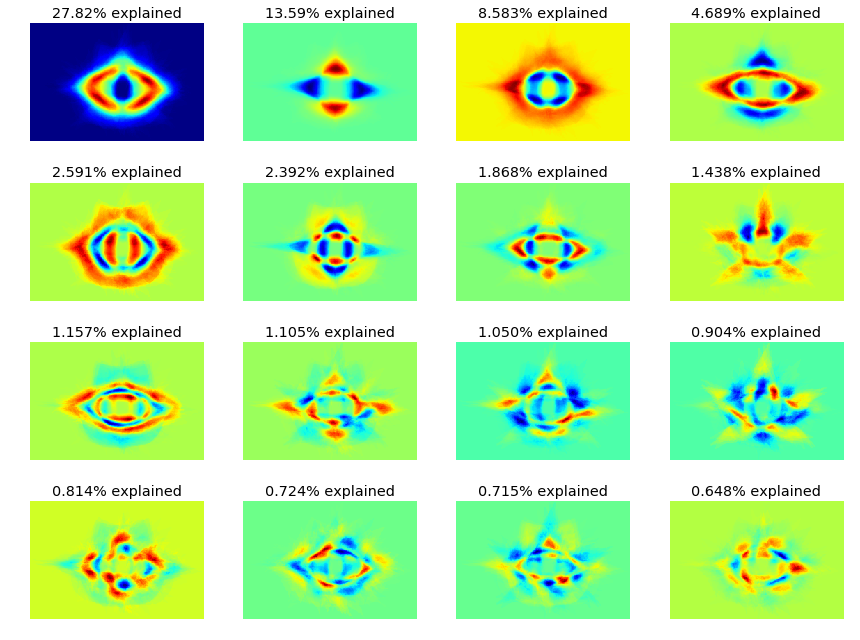

In [6]:
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12,9)
leaf_PCAModel.ShowVarianceDirections(numDirectionsToShow=16)

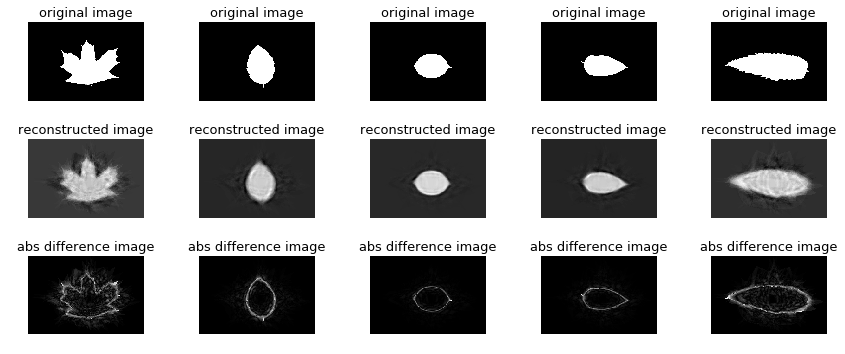

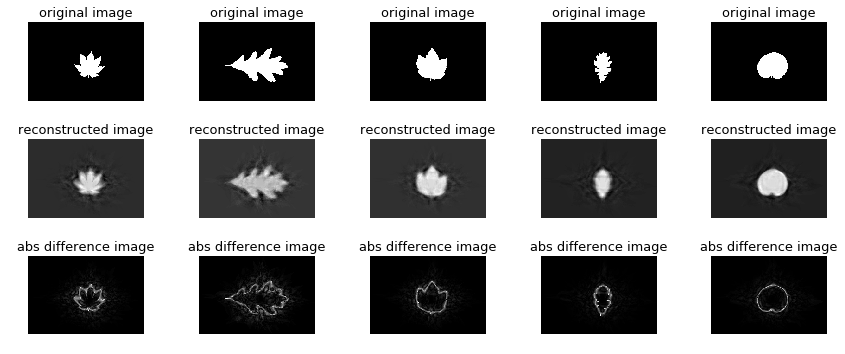

In [7]:
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (12,5)
leaf_PCAModel.ShowReconstructions(X, numReconstructions=10)

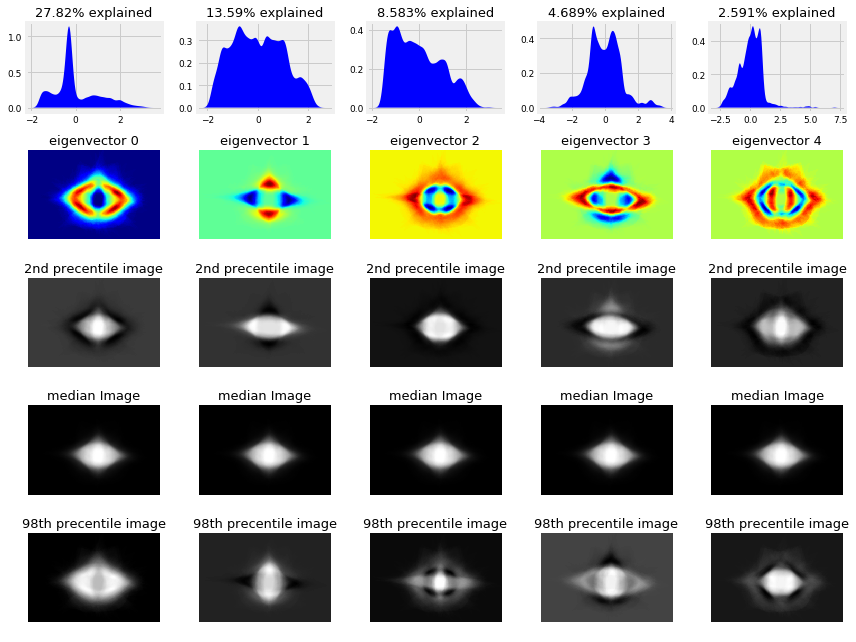

In [8]:
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (12,9)
leaf_PCAModel.ShowModelVariations(numVariations=5)

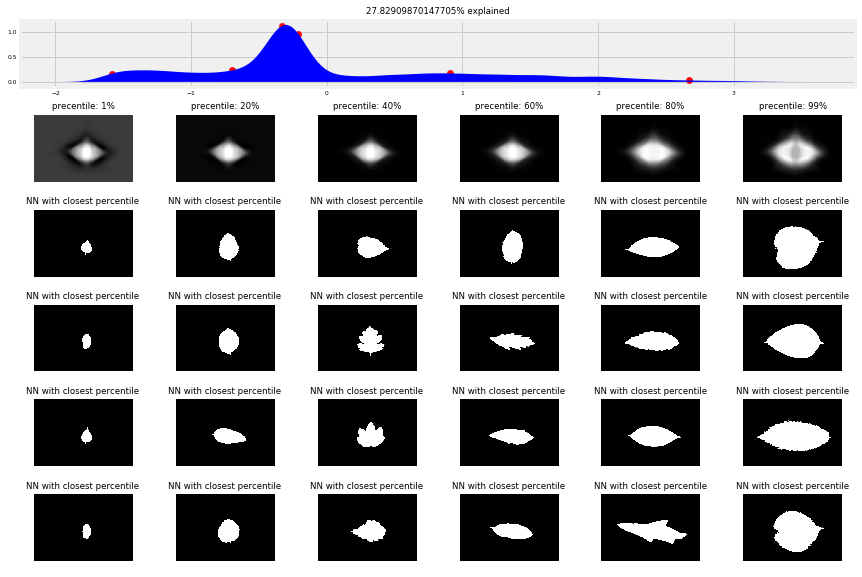

In [9]:
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['figure.figsize'] = (12,8)
leaf_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[0])

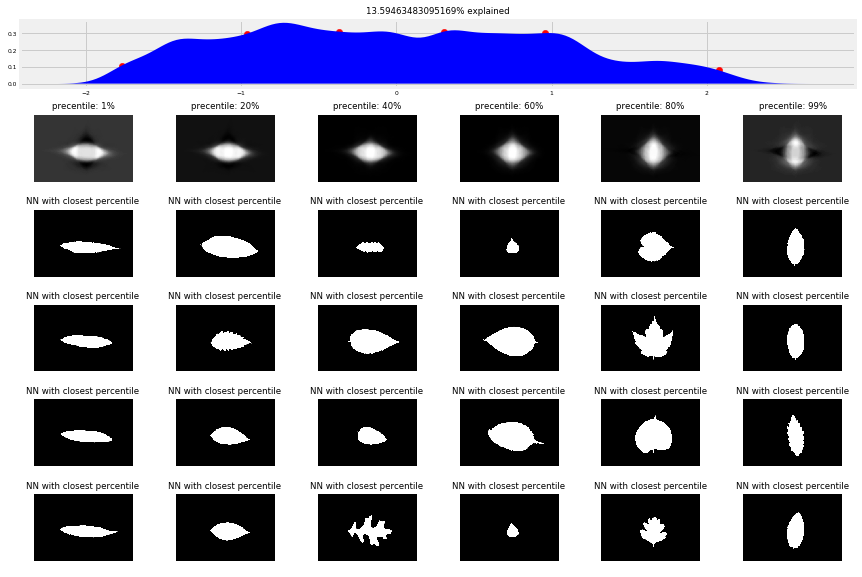

In [10]:
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['figure.figsize'] = (12,8)
leaf_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[1])

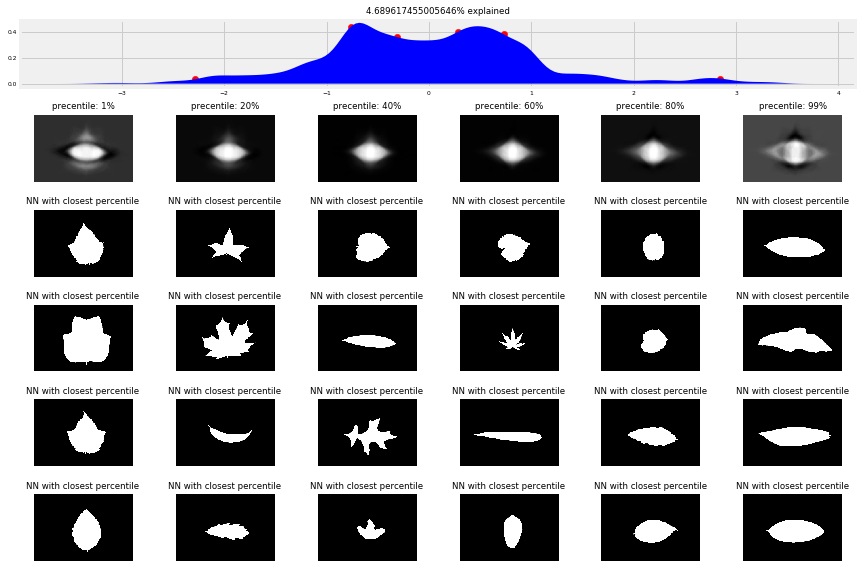

In [11]:
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['figure.figsize'] = (12,8)
leaf_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[3])

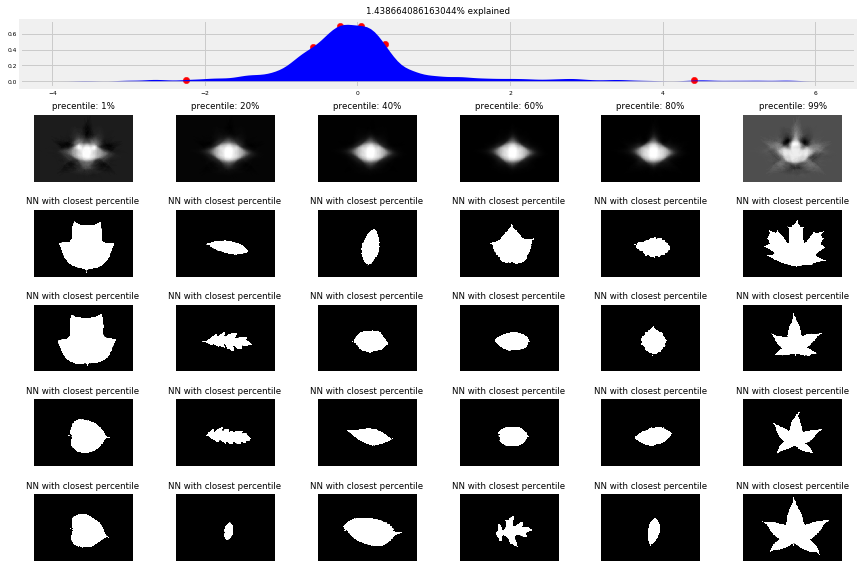

In [12]:
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['figure.figsize'] = (12,8)
leaf_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[7])

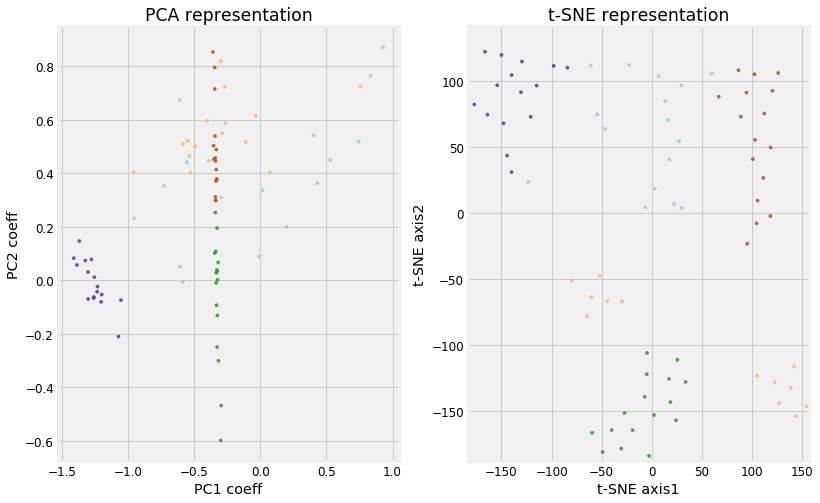

In [13]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

X_train = X[trainIDs-1,:]
y_train = trainLabels

leaf_PCAModel.ShowDataScatterPlotsWithTSNE(X_train, y_train, tSNE_perplexity=10.0)

Text(0.5,1,'Accuracy as function of num PCs')

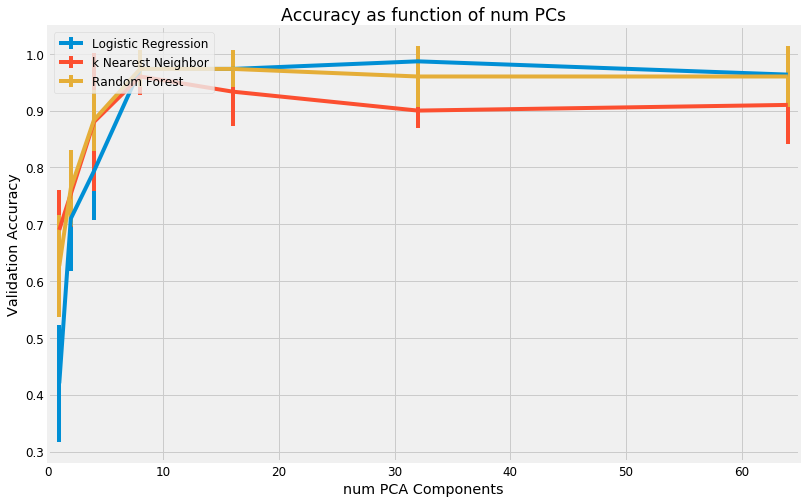

In [14]:
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (12,8)

X_PCA = leaf_PCAModel.RepresentUsingModel(X)

X_PCA_train = X_PCA[trainIDs-1,:]
y_train = trainLabels

numPCsToUse = [1,2,4,8,16,32,64]

logReg = linear_model.LogisticRegression(C=10.0)
kNN = neighbors.KNeighborsClassifier(n_neighbors=7)
RF = ensemble.RandomForestClassifier(n_estimators=100)

logRegMeanAccuracy = []; kNN_MeanAccuracy = []; RF_MeanAccuracy = []
logRegAccuracyStd  = []; kNN_AccuracyStd  = []; RF_AccuracyStd  = []

for numPCs in numPCsToUse:
    stratifiedCV = model_selection.StratifiedKFold(n_splits=5, random_state=1)
    logRegAccuracy = []; kNN_Accuracy = []; RF_Accuracy = []
    for trainInds, validInds in stratifiedCV.split(X_PCA_train, y_train):
        X_train_cv = X_PCA_train[trainInds,:numPCs]
        X_valid_cv = X_PCA_train[validInds,:numPCs]

        y_train_cv = y_train[trainInds]
        y_valid_cv = y_train[validInds]

        logReg.fit(X_train_cv, y_train_cv)
        kNN.fit(X_train_cv, y_train_cv)
        RF.fit(X_train_cv, y_train_cv)
    
        logRegAccuracy.append(accuracy_score(y_valid_cv, logReg.predict(X_valid_cv)))
        kNN_Accuracy.append(accuracy_score(y_valid_cv, kNN.predict(X_valid_cv)))
        RF_Accuracy.append(accuracy_score(y_valid_cv, RF.predict(X_valid_cv)))

    logRegMeanAccuracy.append(np.array(logRegAccuracy).mean())
    logRegAccuracyStd.append(np.array(logRegAccuracy).std())

    kNN_MeanAccuracy.append(np.array(kNN_Accuracy).mean())
    kNN_AccuracyStd.append(np.array(kNN_Accuracy).std())

    RF_MeanAccuracy.append(np.array(RF_Accuracy).mean()) 
    RF_AccuracyStd.append(np.array(RF_Accuracy).std())
        
plt.figure()
plt.errorbar(x=numPCsToUse, y=logRegMeanAccuracy, yerr=logRegAccuracyStd)
plt.errorbar(x=numPCsToUse, y=kNN_MeanAccuracy  , yerr=kNN_AccuracyStd)
plt.errorbar(x=numPCsToUse, y=RF_MeanAccuracy   , yerr=RF_AccuracyStd)
plt.xlim(min(numPCsToUse)-1,max(numPCsToUse)+1); 
plt.legend(['Logistic Regression','k Nearest Neighbor','Random Forest'],loc=2)
plt.xlabel('num PCA Components'); 
plt.ylabel('Validation Accuracy'); 
plt.title('Accuracy as function of num PCs')